In [1]:
# python warning off
import warnings
warnings.filterwarnings('ignore')

# tensorflow warning off
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization, Dropout
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import PIL
#from spp.SpatialPyramidPooling import SpatialPyramidPooling

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17619856019362555687
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7049546957
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5458274043961689480
physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_train, y_train, random_state=42, test_size=0.2
# )
# X_train, adversarial_examples, y_train, adversarial_labels = train_test_split(
#     X_train, y_train, random_state=42, test_size=0.1 
# )

In [5]:
#X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape, adversarial_examples.shape, adversarial_labels.shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

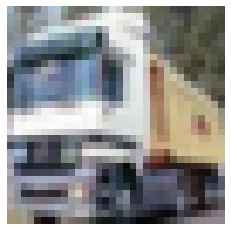

In [6]:
plt.imshow(X_train[1])
plt.axis('off')
plt.show()

In [7]:
y_train[1][0]

9

In [8]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
class_names[y_train[1][0]]

'truck'

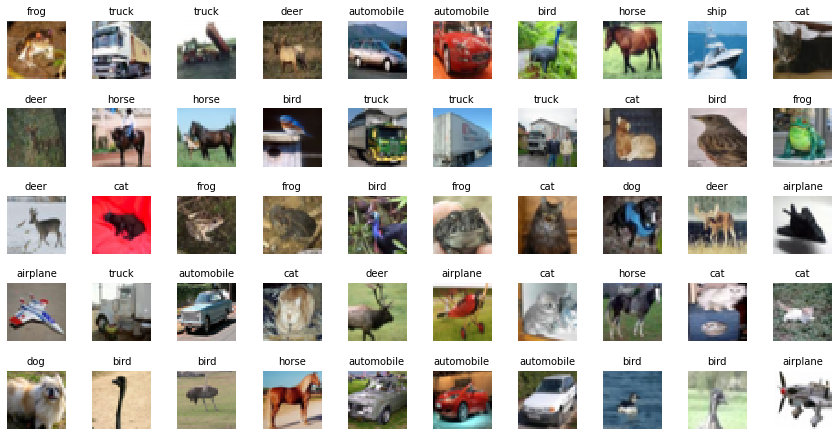

In [9]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index][0]], fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
raw_X_test = X_test

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], 32*32*3))
X_test = scaler.transform(X_test.reshape(X_test.shape[0], 32*32*3))
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


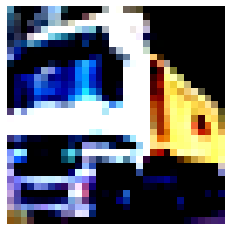

In [11]:
plt.imshow(X_train[1])
plt.axis('off')
plt.show()

In [12]:
raw_y_test = y_test
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [13]:
#학습을 개선하기 위해 가중치 초기화, 배치 정규화, 드랍아웃 활용
#Variable-size image to convolutional layer.
#input_shape에 Width, Height를 None으로 지정해서 variable size를 받을 수 있도록 설정
model = keras.models.Sequential()
model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform', activation='relu', padding='same', input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform', activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), kernel_initializer='he_uniform', activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), kernel_initializer='he_uniform', activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), kernel_initializer='he_uniform', activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), kernel_initializer='he_uniform', activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Variable-size image를 받기 위해서 Flatten 대신 GlobalMaxPooling2D를 사용
model.add(GlobalMaxPooling2D())
#model.add(SpatialPyramidPooling([1, 2, 4]))

#model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 64)    1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 64)    256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 64)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)  

In [14]:
%%time
generator = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, rotation_range=15, horizontal_flip=True)
iterator = generator.flow(X_train, y_train, batch_size=1024)
generator.fit(X_train)

MODEL_DIR_PATH = 'cnn_model/'
if not os.path.exists(MODEL_DIR_PATH):
    os.mkdir(MODEL_DIR_PATH)
model_path = MODEL_DIR_PATH + "{epoch:03d}-{accuracy:.4f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='accuracy', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
result = model.fit_generator(iterator, steps_per_epoch=len(X_train)/32, epochs=100, validation_data=[X_test, y_test], shuffle=True, callbacks=[checkpoint, early_stopping])
#result = model.fit(X_train, y_train, batch_size=1024, epochs=10, validation_data=[X_test, y_test], shuffle=True)

Epoch 1/100
1563/1562 [==============================] - 469s 300ms/step - loss: 0.8349 - accuracy: 0.7096 - val_loss: 0.4546 - val_accuracy: 0.8518
Epoch 2/100
1563/1562 [==============================] - 445s 284ms/step - loss: 0.3509 - accuracy: 0.8813 - val_loss: 0.3412 - val_accuracy: 0.8901
Epoch 3/100
1563/1562 [==============================] - 447s 286ms/step - loss: 0.2423 - accuracy: 0.9180 - val_loss: 0.2963 - val_accuracy: 0.9011
Epoch 4/100
1563/1562 [==============================] - 447s 286ms/step - loss: 0.1877 - accuracy: 0.9366 - val_loss: 0.2910 - val_accuracy: 0.9074
Epoch 5/100
1563/1562 [==============================] - 441s 282ms/step - loss: 0.1554 - accuracy: 0.9476 - val_loss: 0.2994 - val_accuracy: 0.9066
Epoch 6/100
1563/1562 [==============================] - 440s 282ms/step - loss: 0.1338 - accuracy: 0.9551 - val_loss: 0.3191 - val_accuracy: 0.8982
Epoch 7/100
1563/1562 [==============================] - 444s 284ms/step - loss: 0.1179 - accuracy: 0.9609

Epoch 56/100
1563/1562 [==============================] - 438s 280ms/step - loss: 0.0263 - accuracy: 0.9917 - val_loss: 0.3890 - val_accuracy: 0.8948
Epoch 57/100
1563/1562 [==============================] - 438s 280ms/step - loss: 0.0252 - accuracy: 0.9920 - val_loss: 0.3278 - val_accuracy: 0.9042
Epoch 58/100
1563/1562 [==============================] - 437s 280ms/step - loss: 0.0255 - accuracy: 0.9920 - val_loss: 0.3434 - val_accuracy: 0.9043
Epoch 59/100
1563/1562 [==============================] - 438s 280ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.3577 - val_accuracy: 0.9053
Epoch 60/100
1563/1562 [==============================] - 438s 280ms/step - loss: 0.0253 - accuracy: 0.9920 - val_loss: 0.3673 - val_accuracy: 0.8906
Epoch 61/100
1563/1562 [==============================] - 438s 280ms/step - loss: 0.0245 - accuracy: 0.9923 - val_loss: 0.3792 - val_accuracy: 0.8896
Epoch 62/100
1563/1562 [==============================] - 438s 280ms/step - loss: 0.0243 - accuracy:

In [15]:
result.params

{'epochs': 100,
 'steps': 1562.5,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

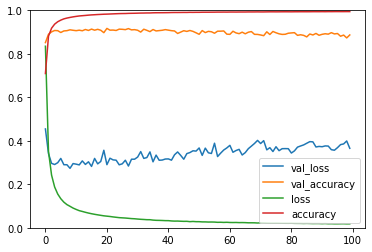

In [16]:
pd.DataFrame(result.history).plot()
plt.gca().set_ylim(0,1)
plt.show()

In [17]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 161us/step


[0.36557895208597185, 0.886900007724762]

In [18]:
predictions = model.predict(X_test)

In [19]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i][0], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i][0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

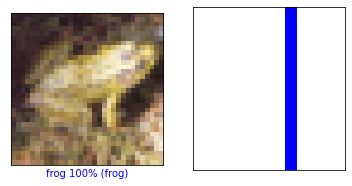

In [20]:
i = 19
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, raw_y_test, raw_X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions, raw_y_test)
plt.show()

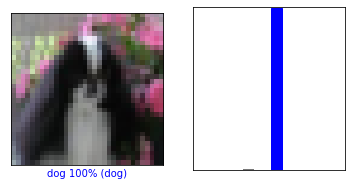

In [21]:
i = 42
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, raw_y_test, raw_X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions, raw_y_test)
plt.show()